In [1]:
import torch.jit
import time
from argparse import ArgumentParser
import numpy as np
import torch
import os
import json

import dlrm.scripts.utils as utils
from dlrm.data.data_loader import get_data_loaders
from dlrm.data.utils import get_categorical_feature_sizes, prefetcher
from dlrm.model.single import Dlrm
from dlrm.utils.checkpointing.serial import SerialCheckpointWriter, make_serial_checkpoint_writer, \
    make_serial_checkpoint_loader

Using the Volta-optimized dot interaction kernels


In [2]:
import pickle
with open('./assets/cat_mappings.pkl', 'rb') as f:
    cat_mappings=pickle.load(f)["cat_mappings"]

In [3]:
movies_mapping = cat_mappings['movieId_factor']

In [4]:
movies_mapping

Int64Index([   296,    306,    307,    665,    899,   1088,   1175,   1217,
              1237,   1250,
            ...
            200178, 200182, 200186, 200188, 200190, 200192, 200194, 139970,
            200726, 200728],
           dtype='int64', length=59047)

In [5]:
nn_to_movies = movies_mapping
movies_to_nn = {}
for i, val in enumerate(movies_mapping):    
    movies_to_nn[val] = i

In [6]:
nn_to_movies[0]

296

In [7]:
movies_to_nn[296]

0

In [8]:
class flag(object):
    def __init__(self):
        
        # Model configuration
        self.embedding_type = "joint" # The type of the embedding operation to use")
        self.embedding_dim = 128 # "Dimensionality of embedding space for categorical features")
        self.top_mlp_sizes = [128, 1] # "Linear layer sizes for the top MLP")
        self.bottom_mlp_sizes = [128, 128] #Linear layer sizes for the bottom MLP")

        self.interaction_op ="cuda_dot" #"Type of interaction operation to perform.")

        self.dataset = "./"
        self.dataset_type = "split" #The type of the dataset to use')

        self.base_device = "cuda" #"Device to run the majority of the model operations")
        self.amp = False #If True the script will use Automatic Mixed Precision")
        self.optimized_mlp = True #Use an optimized implementation of MLP from apex")
        self.max_table_size = None #Maximum number of rows per embedding table, by default equal to the number of unique values for each categorical variable")
        self.num_numerical_features = 171
        self.hash_indices = False

FLAGS = flag()

In [9]:

print("Creating model")

categorical_sizes_file = os.path.join("./model_size.json")
with open(categorical_sizes_file) as f:
    categorical_sizes = json.load(f).values()
categorical_sizes = list(categorical_sizes)
   
model_config = {
    'top_mlp_sizes': FLAGS.top_mlp_sizes,
    'bottom_mlp_sizes': FLAGS.bottom_mlp_sizes,
    'embedding_type': FLAGS.embedding_type,
    'embedding_dim': FLAGS.embedding_dim,
    'interaction_op': FLAGS.interaction_op,
    'categorical_feature_sizes': categorical_sizes,
    'num_numerical_features': FLAGS.num_numerical_features,
    'hash_indices': FLAGS.hash_indices,
    'use_cpp_mlp': FLAGS.optimized_mlp,
    'fp16': FLAGS.amp,
    'base_device': FLAGS.base_device,
}

model = Dlrm.from_dict(model_config)
print(model)

Creating model
Dlrm(
  interaction_op=cuda_dot, hash_indices=False
  (bottom_model): DlrmBottom(
    (embeddings): JointEmbedding(
      offsets=[     0 162541 221588 221724 223363 223365 223367 223369 223371 223373
       223375 223377 223379 223381 223383 223385 223387 223389 223391 223393
       223395 223397 223399 223401 223403]
      (embedding): Embedding(223403, 128)
    )
    (mlp): CppMlp(
      (mlp): MLP(MLP sizes: [171, 128, 128], Bias=1, activation=1)
    )
  )
  (top_model): DlrmTop(
    (mlp): CppMlp(
      (mlp): MLP(MLP sizes: [429, 128], Bias=1, activation=1)
    )
    (out): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [ ]:
#model.bottom_model.mlp.layers[0].weight.shape


In [10]:
checkpoint_loader = make_serial_checkpoint_loader(
            embedding_indices=range(len(get_categorical_feature_sizes(FLAGS))),
            device="cpu"
        )
checkpoint_loader.load_checkpoint(model, ".././movie_lens_dlrm_v4")
model.eval()
model.to(FLAGS.base_device)

feature sizes:  [162542, 59048, 137, 1640, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


/workspace/dlrm/dlrm/utils/checkpointing/model.py:128: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(array).to(self._device)


Dlrm(
  interaction_op=cuda_dot, hash_indices=False
  (bottom_model): DlrmBottom(
    (embeddings): JointEmbedding(
      offsets=[     0 162541 221588 221724 223363 223365 223367 223369 223371 223373
       223375 223377 223379 223381 223383 223385 223387 223389 223391 223393
       223395 223397 223399 223401 223403]
      (embedding): Embedding(223403, 128)
    )
    (mlp): CppMlp(
      (mlp): MLP(MLP sizes: [171, 128, 128], Bias=1, activation=1)
    )
  )
  (top_model): DlrmTop(
    (mlp): CppMlp(
      (mlp): MLP(MLP sizes: [429, 128], Bias=1, activation=1)
    )
    (out): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [11]:
model.bottom_model.embeddings.embedding.weight.shape

torch.Size([223403, 128])

In [12]:
embedding = model.bottom_model.embeddings.embedding.weight.detach().cpu().numpy()

In [13]:
item_embedding = embedding[162541:162541+59047]
item_embedding.shape

(59047, 128)

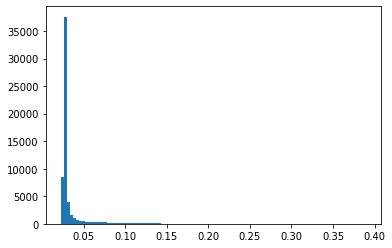

In [14]:
import matplotlib.pyplot as plt
plt.hist(np.linalg.norm(item_embedding, axis=1),100);

In [15]:
from scipy.spatial.distance import cdist
def find_similar_movies(nn_movie_id, item_embedding, k=10, metric='cosine'):
    sim = -cdist(item_embedding, item_embedding[nn_movie_id].reshape(1, -1), metric=metric)
    #sim = np.matmul(item_embedding, item_embedding[nn_movie_id].transpose())
    return sim.squeeze().argsort()[-k:][::-1]

In [16]:
import pandas as pd
movies = pd.read_csv("./data/ml-25m/movies.csv", index_col="movieId")
print(len(movies))


62423


In [17]:
movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [18]:
movie_ID = 1 
print("Query: ", movies.loc[movie_ID]["title"], movies.loc[movie_ID]["genres"])

print("movies_to_nn[movie_ID]", movies_to_nn[movie_ID])
print("Similar movies: ")
similar_movies = find_similar_movies(movies_to_nn[movie_ID], item_embedding)
print(similar_movies)

for i in similar_movies:
    if i==0:
        continue
    print(nn_to_movies[i], movies.loc[nn_to_movies[i]]["title"], movies.loc[nn_to_movies[i]]["genres"])

Query:  Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
movies_to_nn[movie_ID] 70
Similar movies: 
[  70  199  174  193  652  151 1891  187  170  806]
1 Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
4886 Monsters, Inc. (2001) Adventure|Animation|Children|Comedy|Fantasy
3114 Toy Story 2 (1999) Adventure|Animation|Children|Comedy|Fantasy
4306 Shrek (2001) Adventure|Animation|Children|Comedy|Fantasy|Romance
78499 Toy Story 3 (2010) Adventure|Animation|Children|Comedy|Fantasy|IMAX
2294 Antz (1998) Adventure|Animation|Children|Comedy|Fantasy
673 Space Jam (1996) Adventure|Animation|Children|Comedy|Fantasy|Sci-Fi
4016 Emperor's New Groove, The (2000) Adventure|Animation|Children|Comedy|Fantasy
2987 Who Framed Roger Rabbit? (1988) Adventure|Animation|Children|Comedy|Crime|Fantasy|Mystery
134853 Inside Out (2015) Adventure|Animation|Children|Comedy|Drama|Fantasy


In [19]:
for movie_ID in range(1000):
    try:
        print("Query: ", movies.loc[movie_ID]["title"], movies.loc[movie_ID]["genres"])

        print("Similar movies: ")
        similar_movies = find_similar_movies(movies_to_nn[movie_ID], item_embedding)

        for i in similar_movies:
            if i==0:
                continue
            print(nn_to_movies[i], movies.loc[nn_to_movies[i]]["title"], movies.loc[nn_to_movies[i]]["genres"])
        print('===============\n')
    except Exception as e:
        print(e)
        pass

0
Query:  Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
Similar movies: 
1 Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
4886 Monsters, Inc. (2001) Adventure|Animation|Children|Comedy|Fantasy
3114 Toy Story 2 (1999) Adventure|Animation|Children|Comedy|Fantasy
4306 Shrek (2001) Adventure|Animation|Children|Comedy|Fantasy|Romance
78499 Toy Story 3 (2010) Adventure|Animation|Children|Comedy|Fantasy|IMAX
2294 Antz (1998) Adventure|Animation|Children|Comedy|Fantasy
673 Space Jam (1996) Adventure|Animation|Children|Comedy|Fantasy|Sci-Fi
4016 Emperor's New Groove, The (2000) Adventure|Animation|Children|Comedy|Fantasy
2987 Who Framed Roger Rabbit? (1988) Adventure|Animation|Children|Comedy|Crime|Fantasy|Mystery
134853 Inside Out (2015) Adventure|Animation|Children|Comedy|Drama|Fantasy

Query:  Jumanji (1995) Adventure|Children|Fantasy
Similar movies: 
2 Jumanji (1995) Adventure|Children|Fantasy
4896 Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and t

18 Four Rooms (1995) Comedy
333 Tommy Boy (1995) Comedy
19 Ace Ventura: When Nature Calls (1995) Comedy
5 Father of the Bride Part II (1995) Comedy
104 Happy Gilmore (1996) Comedy
223 Clerks (1994) Comedy
216 Billy Madison (1995) Comedy
1485 Liar Liar (1997) Comedy
2539 Analyze This (1999) Comedy
141 Birdcage, The (1996) Comedy

Query:  Ace Ventura: When Nature Calls (1995) Comedy
Similar movies: 
19 Ace Ventura: When Nature Calls (1995) Comedy
223 Clerks (1994) Comedy
344 Ace Ventura: Pet Detective (1994) Comedy
1485 Liar Liar (1997) Comedy
104 Happy Gilmore (1996) Comedy
5 Father of the Bride Part II (1995) Comedy
3948 Meet the Parents (2000) Comedy
141 Birdcage, The (1996) Comedy
520 Robin Hood: Men in Tights (1993) Comedy
2918 Ferris Bueller's Day Off (1986) Comedy

Query:  Money Train (1995) Action|Comedy|Crime|Drama|Thriller
Similar movies: 
20 Money Train (1995) Action|Comedy|Crime|Drama|Thriller
145 Bad Boys (1995) Action|Comedy|Crime|Drama|Thriller
7007 Last Boy Scout, The (19

35 Carrington (1995) Drama|Romance
2269 Indecent Proposal (1993) Drama|Romance
515 Remains of the Day, The (1993) Drama|Romance
222 Circle of Friends (1995) Drama|Romance
1680 Sliding Doors (1998) Drama|Romance
381 When a Man Loves a Woman (1994) Drama|Romance
1059 William Shakespeare's Romeo + Juliet (1996) Drama|Romance
106920 Her (2013) Drama|Romance|Sci-Fi
46 How to Make an American Quilt (1995) Drama|Romance
105 Bridges of Madison County, The (1995) Drama|Romance

Query:  Dead Man Walking (1995) Crime|Drama
Similar movies: 
36 Dead Man Walking (1995) Crime|Drama
3147 Green Mile, The (1999) Crime|Drama
2329 American History X (1998) Crime|Drama
16 Casino (1995) Crime|Drama
318 Shawshank Redemption, The (1994) Crime|Drama
1213 Goodfellas (1990) Crime|Drama
1466 Donnie Brasco (1997) Crime|Drama
5989 Catch Me If You Can (2002) Crime|Drama
55820 No Country for Old Men (2007) Crime|Drama
431 Carlito's Way (1993) Crime|Drama

Query:  Across the Sea of Time (1995) Documentary|IMAX
Similar

53 Lamerica (1994) Adventure|Drama
3494 True Grit (1969) Adventure|Drama|Western
3927 Fantastic Voyage (1966) Adventure|Sci-Fi
8607 Tokyo Godfathers (2003) Adventure|Animation|Drama
5446 Rabbit-Proof Fence (2002) Adventure|Drama
177497 Hostiles (2017) Adventure|Drama|Western
8684 Man Escaped, A (Un  condamné à mort s'est échappé ou Le vent souffle où il veut) (1956) Adventure|Drama
3470 Dersu Uzala (1975) Adventure|Drama
105197 Nebraska (2013) Adventure|Drama
7087 Passage to India, A (1984) Adventure|Drama

Query:  Big Green, The (1995) Children|Comedy
Similar movies: 
54 Big Green, The (1995) Children|Comedy
1021 Angels in the Outfield (1994) Children|Comedy
374 Richie Rich (1994) Children|Comedy
87 Dunston Checks In (1996) Children|Comedy
586 Home Alone (1990) Children|Comedy
6794 Beethoven's 2nd (1993) Children|Comedy
2953 Home Alone 2: Lost in New York (1992) Children|Comedy
575 Little Rascals, The (1994) Children|Comedy
1359 Jingle All the Way (1996) Children|Comedy
1707 Home Alon

Similar movies: 
70 From Dusk Till Dawn (1996) Action|Comedy|Horror|Thriller
46965 Snakes on a Plane (2006) Action|Comedy|Horror|Thriller
799 Frighteners, The (1996) Comedy|Horror|Thriller
1321 American Werewolf in London, An (1981) Comedy|Horror|Thriller
4128 Lost Boys, The (1987) Comedy|Horror|Thriller
3264 Buffy the Vampire Slayer (1992) Action|Comedy|Horror
1407 Scream (1996) Comedy|Horror|Mystery|Thriller
93840 Cabin in the Woods, The (2012) Comedy|Horror|Sci-Fi|Thriller
3273 Scream 3 (2000) Comedy|Horror|Mystery|Thriller
189203 Upgrade (2018) Action|Comedy|Horror|Sci-Fi|Thriller

Query:  Fair Game (1995) Action
Similar movies: 
71 Fair Game (1995) Action
667 Bloodsport 2 (a.k.a. Bloodsport II: The Next Kumite) (1996) Action
9 Sudden Death (1995) Action
4866 Last Castle, The (2001) Action
2531 Battle for the Planet of the Apes (1973) Action|Sci-Fi
4387 Kiss of the Dragon (2001) Action
2641 Superman II (1980) Action|Sci-Fi
204 Under Siege 2: Dark Territory (1995) Action
96737 Dredd

87 Dunston Checks In (1996) Children|Comedy
374 Richie Rich (1994) Children|Comedy
1021 Angels in the Outfield (1994) Children|Comedy
1359 Jingle All the Way (1996) Children|Comedy
6794 Beethoven's 2nd (1993) Children|Comedy
2042 D2: The Mighty Ducks (1994) Children|Comedy
1005 D3: The Mighty Ducks (1996) Children|Comedy
575 Little Rascals, The (1994) Children|Comedy
1707 Home Alone 3 (1997) Children|Comedy
6951 Cat in the Hat, The (2003) Children|Comedy

Query:  Black Sheep (1996) Comedy
Similar movies: 
88 Black Sheep (1996) Comedy
223 Clerks (1994) Comedy
5 Father of the Bride Part II (1995) Comedy
785 Kingpin (1996) Comedy
104 Happy Gilmore (1996) Comedy
19 Ace Ventura: When Nature Calls (1995) Comedy
141 Birdcage, The (1996) Comedy
2539 Analyze This (1999) Comedy
2599 Election (1999) Comedy
1485 Liar Liar (1997) Comedy

Query:  Nick of Time (1995) Action|Thriller
Similar movies: 
89 Nick of Time (1995) Action|Thriller
376 River Wild, The (1994) Action|Thriller
227 Drop Zone (1994)

105 Bridges of Madison County, The (1995) Drama|Romance
509 Piano, The (1993) Drama|Romance
17 Sense and Sensibility (1995) Drama|Romance
515 Remains of the Day, The (1993) Drama|Romance
1393 Jerry Maguire (1996) Drama|Romance
1059 William Shakespeare's Romeo + Juliet (1996) Drama|Romance
25 Leaving Las Vegas (1995) Drama|Romance
802 Phenomenon (1996) Drama|Romance
215 Before Sunrise (1995) Drama|Romance
3556 Virgin Suicides, The (1999) Drama|Romance

Query:  Nobody Loves Me (Keiner liebt mich) (1994) Comedy|Drama
Similar movies: 
106 Nobody Loves Me (Keiner liebt mich) (1994) Comedy|Drama
153977 Lucid (2005) (no genres listed)
178783 Marecek, Pass Me the Pen! (1976) Children|Comedy
201300 Discarnate (2019) Horror|Thriller
192953 Ghost in the Shell: Stand Alone Complex - Individual Eleven (2006) Animation|Sci-Fi
166645 Mandıra Filozofu (2014) Comedy
148879 Nunca en horas de clase (1978) Comedy
116513 'Master Harold' ... And the Boys (2010) Drama
176579 Cage Dive (2017) Drama|Horror|Thr

122 Boomerang (1992) Comedy|Romance
1188 Strictly Ballroom (1992) Comedy|Romance
1307 When Harry Met Sally... (1989) Comedy|Romance
2108 L.A. Story (1991) Comedy|Romance
7293 50 First Dates (2004) Comedy|Romance
4489 Coming to America (1988) Comedy|Romance
5299 My Big Fat Greek Wedding (2002) Comedy|Romance
5620 Sweet Home Alabama (2002) Comedy|Romance
2424 You've Got Mail (1998) Comedy|Romance
4018 What Women Want (2000) Comedy|Romance

Query:  Chungking Express (Chung Hing sam lam) (1994) Drama|Mystery|Romance
Similar movies: 
123 Chungking Express (Chung Hing sam lam) (1994) Drama|Mystery|Romance
2875 Sommersby (1993) Drama|Mystery|Romance
8638 Before Sunset (2004) Drama|Romance
2020 Dangerous Liaisons (1988) Drama|Romance
1296 Room with a View, A (1986) Drama|Romance
5992 Hours, The (2002) Drama|Romance
39183 Brokeback Mountain (2005) Drama|Romance
2942 Flashdance (1983) Drama|Romance
8981 Closer (2004) Drama|Romance
8533 Notebook, The (2004) Drama|Romance

Query:  Star Maker, The 

139 Target (1995) Action|Drama
172015 Metamorphosis (2003) Drama|Fantasy
189501 Superfights (1995) Action
125325 Margie (1946) (no genres listed)
80141 Christmas Toy, The (1986) Children|Musical
123026 Horror Island (1941) Horror
135955 Ramrod (1947) Western
4145 Fever (1999) Thriller
202765 Dollhouse (2012) Drama
185889 ארבינקא (1967) Comedy|Crime|Romance

Query:  Up Close and Personal (1996) Drama|Romance
Similar movies: 
140 Up Close and Personal (1996) Drama|Romance
4014 Chocolat (2000) Drama|Romance
3556 Virgin Suicides, The (1999) Drama|Romance
1357 Shine (1996) Drama|Romance
1680 Sliding Doors (1998) Drama|Romance
17 Sense and Sensibility (1995) Drama|Romance
1059 William Shakespeare's Romeo + Juliet (1996) Drama|Romance
802 Phenomenon (1996) Drama|Romance
515 Remains of the Day, The (1993) Drama|Romance
509 Piano, The (1993) Drama|Romance

Query:  Birdcage, The (1996) Comedy
Similar movies: 
141 Birdcage, The (1996) Comedy
344 Ace Ventura: Pet Detective (1994) Comedy
223 Clerks

157 Canadian Bacon (1995) Comedy|War
750 Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) Comedy|War
1663 Stripes (1981) Comedy|War
1078 Bananas (1971) Comedy|War
3022 General, The (1926) Comedy|War
3448 Good Morning, Vietnam (1987) Comedy|Drama|War
4349 Catch-22 (1970) Comedy|War
4015 Dude, Where's My Car? (2000) Comedy|Sci-Fi
1965 Repo Man (1984) Comedy|Sci-Fi
5060 M*A*S*H (a.k.a. MASH) (1970) Comedy|Drama|War

Query:  Casper (1995) Adventure|Children
Similar movies: 
158 Casper (1995) Adventure|Children
2046 Flight of the Navigator (1986) Adventure|Children|Sci-Fi
362 Jungle Book, The (1994) Adventure|Children|Romance
986 Fly Away Home (1996) Adventure|Children
2 Jumanji (1995) Adventure|Children|Fantasy
609 Homeward Bound II: Lost in San Francisco (1996) Adventure|Children
4896 Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001) Adventure|Children|Fantasy
1017 Swiss Family Robinson (1960) Adventure|Children
2161 

171 Jeffrey (1995) Comedy|Drama
1120 People vs. Larry Flynt, The (1996) Comedy|Drama
218 Boys on the Side (1995) Comedy|Drama
1810 Primary Colors (1998) Comedy|Drama
2318 Happiness (1998) Comedy|Drama
1042 That Thing You Do! (1996) Comedy|Drama
308 Three Colors: White (Trzy kolory: Bialy) (1994) Comedy|Drama
1476 Private Parts (1997) Comedy|Drama
994 Big Night (1996) Comedy|Drama
3477 Empire Records (1995) Comedy|Drama

Query:  Johnny Mnemonic (1995) Action|Sci-Fi|Thriller
Similar movies: 
172 Johnny Mnemonic (1995) Action|Sci-Fi|Thriller
1882 Godzilla (1998) Action|Sci-Fi|Thriller
5903 Equilibrium (2002) Action|Sci-Fi|Thriller
541 Blade Runner (1982) Action|Sci-Fi|Thriller
2571 Matrix, The (1999) Action|Sci-Fi|Thriller
379 Timecop (1994) Action|Sci-Fi|Thriller
1240 Terminator, The (1984) Action|Sci-Fi|Thriller
2600 eXistenZ (1999) Action|Sci-Fi|Thriller
303 Quick and the Dead, The (1995) Action|Thriller|Western
338 Virtuosity (1995) Action|Sci-Fi|Thriller

Query:  Judge Dredd (1995) A

188 Prophecy, The (1995) Fantasy|Horror|Mystery
3081 Sleepy Hollow (1999) Fantasy|Horror|Mystery|Romance
5128 Queen of the Damned (2002) Fantasy|Horror
606 Candyman: Farewell to the Flesh (1995) Fantasy|Horror
85412 Troll Hunter, The (Trolljegeren) (2010) Fantasy|Horror
61240 Let the Right One In (Låt den rätte komma in) (2008) Drama|Fantasy|Horror|Romance
2454 Fly, The (1958) Horror|Mystery|Sci-Fi
1346 Cat People (1982) Drama|Fantasy|Horror
3476 Jacob's Ladder (1990) Horror|Mystery
175197 The Dark Tower (2017) Fantasy|Horror|Sci-Fi|Western

Query:  Reckless (1995) Comedy|Fantasy
Similar movies: 
189 Reckless (1995) Comedy|Fantasy
2622 William Shakespeare's A Midsummer Night's Dream (1999) Comedy|Fantasy
1126 Drop Dead Fred (1991) Comedy|Fantasy
718 Visitors, The (Visiteurs, Les) (1993) Comedy|Fantasy|Sci-Fi
829 Joe's Apartment (1996) Comedy|Fantasy|Musical
3258 Death Becomes Her (1992) Comedy|Fantasy
53993 Evan Almighty (2007) Comedy|Fantasy
3784 Kid, The (2000) Comedy|Fantasy
2134 We

206 Unzipped (1995) Documentary
6331 Spellbound (2002) Documentary
1289 Koyaanisqatsi (a.k.a. Koyaanisqatsi: Life Out of Balance) (1983) Documentary
162 Crumb (1994) Documentary
8622 Fahrenheit 9/11 (2004) Documentary
2064 Roger & Me (1989) Documentary
1189 Thin Blue Line, The (1988) Documentary
5669 Bowling for Columbine (2002) Documentary
6380 Capturing the Friedmans (2003) Documentary
246 Hoop Dreams (1994) Documentary

Query:  Walk in the Clouds, A (1995) Drama|Romance
Similar movies: 
207 Walk in the Clouds, A (1995) Drama|Romance
515 Remains of the Day, The (1993) Drama|Romance
802 Phenomenon (1996) Drama|Romance
1357 Shine (1996) Drama|Romance
17 Sense and Sensibility (1995) Drama|Romance
25 Leaving Las Vegas (1995) Drama|Romance
3556 Virgin Suicides, The (1999) Drama|Romance
1059 William Shakespeare's Romeo + Juliet (1996) Drama|Romance
4014 Chocolat (2000) Drama|Romance
1721 Titanic (1997) Drama|Romance

Query:  Waterworld (1995) Action|Adventure|Sci-Fi
Similar movies: 
208 Wa

224 Don Juan DeMarco (1995) Comedy|Drama|Romance
11 American President, The (1995) Comedy|Drama|Romance
58 Postman, The (Postino, Il) (1994) Comedy|Drama|Romance
852 Tin Cup (1996) Comedy|Drama|Romance
539 Sleepless in Seattle (1993) Comedy|Drama|Romance
1639 Chasing Amy (1997) Comedy|Drama|Romance
838 Emma (1996) Comedy|Drama|Romance
372 Reality Bites (1994) Comedy|Drama|Romance
52 Mighty Aphrodite (1995) Comedy|Drama|Romance
2396 Shakespeare in Love (1998) Comedy|Drama|Romance

Query:  Disclosure (1994) Drama|Thriller
Similar movies: 
225 Disclosure (1994) Drama|Thriller
3755 Perfect Storm, The (2000) Drama|Thriller
454 Firm, The (1993) Drama|Thriller
805 Time to Kill, A (1996) Drama|Thriller
3006 Insider, The (1999) Drama|Thriller
3510 Frequency (2000) Drama|Thriller
3409 Final Destination (2000) Drama|Thriller
230 Dolores Claiborne (1995) Drama|Thriller
4235 Amores Perros (Love's a Bitch) (2000) Drama|Thriller
79 Juror, The (1996) Drama|Thriller

Query:  Dream Man (1995) Thriller
S

241 Fluke (1995) Children|Drama
262 Little Princess, A (1995) Children|Drama
531 Secret Garden, The (1993) Children|Drama
34 Babe (1995) Children|Drama
27 Now and Then (1995) Children|Drama
1097 E.T. the Extra-Terrestrial (1982) Children|Drama|Sci-Fi
917 Little Princess, The (1939) Children|Drama
1012 Old Yeller (1957) Children|Drama
3189 My Dog Skip (1999) Children|Drama
1302 Field of Dreams (1989) Children|Drama|Fantasy

Query:  Farinelli: il castrato (1994) Drama|Musical
Similar movies: 
242 Farinelli: il castrato (1994) Drama|Musical
1298 Pink Floyd: The Wall (1982) Drama|Musical
3910 Dancer in the Dark (2000) Drama|Musical
1951 Oliver! (1968) Drama|Musical
4857 Fiddler on the Roof (1971) Drama|Musical
1416 Evita (1996) Drama|Musical
477 What's Love Got to Do with It? (1993) Drama|Musical
3545 Cabaret (1972) Drama|Musical
49824 Dreamgirls (2006) Drama|Musical
1088 Dirty Dancing (1987) Drama|Musical|Romance

Query:  Gordy (1995) Children|Comedy|Fantasy
Similar movies: 
243 Gordy (19

259 Kiss of Death (1995) Crime|Drama|Thriller
4326 Mississippi Burning (1988) Crime|Drama|Thriller
2912 Limey, The (1999) Crime|Drama|Thriller
2391 Simple Plan, A (1998) Crime|Drama|Thriller
707 Mulholland Falls (1996) Crime|Drama|Thriller
1729 Jackie Brown (1997) Crime|Drama|Thriller
2268 Few Good Men, A (1992) Crime|Drama|Thriller
482 Killing Zoe (1994) Crime|Drama|Thriller
55118 Eastern Promises (2007) Crime|Drama|Thriller
3298 Boiler Room (2000) Crime|Drama|Thriller

Query:  Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
Similar movies: 
260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
1210 Star Wars: Episode VI - Return of the Jedi (1983) Action|Adventure|Sci-Fi
1196 Star Wars: Episode V - The Empire Strikes Back (1980) Action|Adventure|Sci-Fi
59315 Iron Man (2008) Action|Adventure|Sci-Fi
112852 Guardians of the Galaxy (2014) Action|Adventure|Sci-Fi
33493 Star Wars: Episode III - Revenge of the Sith (2005) Action|Adventure|Sci-Fi
2640 Superm

276 Milk Money (1994) Comedy|Romance
357 Four Weddings and a Funeral (1994) Comedy|Romance
440 Dave (1993) Comedy|Romance
339 While You Were Sleeping (1995) Comedy|Romance
252 I.Q. (1994) Comedy|Romance
497 Much Ado About Nothing (1993) Comedy|Romance
180 Mallrats (1995) Comedy|Romance
1569 My Best Friend's Wedding (1997) Comedy|Romance
2572 10 Things I Hate About You (1999) Comedy|Romance
4973 Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001) Comedy|Romance

Query:  Miracle on 34th Street (1994) Drama
Similar movies: 
277 Miracle on 34th Street (1994) Drama
62 Mr. Holland's Opus (1995) Drama
3160 Magnolia (1999) Drama
300 Quiz Show (1994) Drama
337 What's Eating Gilbert Grape (1993) Drama
1358 Sling Blade (1996) Drama
1673 Boogie Nights (1997) Drama
508 Philadelphia (1993) Drama
4022 Cast Away (2000) Drama
2541 Cruel Intentions (1999) Drama

Query:  Miami Rhapsody (1995) Comedy
Similar movies: 
278 Miami Rhapsody (1995) Comedy
514 Ref, The (1994) Comedy
1665 Bean (1997) Comedy
144 

295 Pyromaniac's Love Story, A (1995) Comedy|Romance
3052 Dogma (1999) Adventure|Comedy|Fantasy
1197 Princess Bride, The (1987) Action|Adventure|Comedy|Fantasy|Romance
2794 European Vacation (aka National Lampoon's European Vacation) (1985) Adventure|Comedy|Romance
1894 Six Days Seven Nights (1998) Adventure|Comedy|Romance
1136 Monty Python and the Holy Grail (1975) Adventure|Comedy|Fantasy
691 Mrs. Winterbourne (1996) Comedy|Romance
30810 Life Aquatic with Steve Zissou, The (2004) Adventure|Comedy|Fantasy
101 Bottle Rocket (1996) Adventure|Comedy|Crime|Romance
30793 Charlie and the Chocolate Factory (2005) Adventure|Children|Comedy|Fantasy|IMAX

Query:  Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
Similar movies: 
608 Fargo (1996) Comedy|Crime|Drama|Thriller
21 Get Shorty (1995) Comedy|Crime|Thriller
57669 In Bruges (2008) Comedy|Crime|Drama|Thriller
4011 Snatch (2000) Comedy|Crime|Thriller
2542 Lock, Stock & Two Smoking Barrels (1998) Comedy|Crime|Thriller
6003 Confessions of a Da

312 Stuart Saves His Family (1995) Comedy
3146 Deuce Bigalow: Male Gigolo (1999) Comedy
1513 Romy and Michele's High School Reunion (1997) Comedy
830 First Wives Club, The (1996) Comedy
1449 Waiting for Guffman (1996) Comedy
785 Kingpin (1996) Comedy
1614 In & Out (1997) Comedy
4816 Zoolander (2001) Comedy
203 To Wong Foo, Thanks for Everything! Julie Newmar (1995) Comedy
2407 Cocoon (1985) Comedy|Sci-Fi

Query:  Swan Princess, The (1994) Animation|Children
Similar movies: 
313 Swan Princess, The (1994) Animation|Children
2137 Charlotte's Web (1973) Animation|Children
3483 Road to El Dorado, The (2000) Animation|Children
3213 Batman: Mask of the Phantasm (1993) Animation|Children
95654 Geri's Game (1997) Animation|Children
3799 Pokémon the Movie 2000 (2000) Animation|Children
616 Aristocats, The (1970) Animation|Children
4090 Brave Little Toaster, The (1987) Animation|Children
3287 Tigger Movie, The (2000) Animation|Children
3964 Adventures of Ichabod and Mr. Toad, The (1949) Animation

331 Tom & Viv (1994) Drama
8914 Primer (2004) Drama|Sci-Fi
535 Short Cuts (1993) Drama
55908 Man from Earth, The (2007) Drama|Sci-Fi
428 Bronx Tale, A (1993) Drama
781 Stealing Beauty (1996) Drama
1730 Kundun (1997) Drama
147 Basketball Diaries, The (1995) Drama
8147 Charly (1968) Drama|Sci-Fi
307 Three Colors: Blue (Trois couleurs: Bleu) (1993) Drama

Query:  Village of the Damned (1995) Horror|Sci-Fi
Similar movies: 
332 Village of the Damned (1995) Horror|Sci-Fi
196 Species (1995) Horror|Sci-Fi
2428 Faculty, The (1998) Horror|Sci-Fi
177 Lord of Illusions (1995) Horror
56145 Mist, The (2007) Horror|Sci-Fi
1862 Species II (1998) Horror|Sci-Fi
2901 Phantasm (1979) Horror|Sci-Fi
2456 Fly II, The (1989) Horror|Sci-Fi
1924 Plan 9 from Outer Space (1959) Horror|Sci-Fi
1334 Blob, The (1958) Horror|Sci-Fi

Query:  Tommy Boy (1995) Comedy
Similar movies: 
333 Tommy Boy (1995) Comedy
223 Clerks (1994) Comedy
19 Ace Ventura: When Nature Calls (1995) Comedy
1485 Liar Liar (1997) Comedy
344 Ace V

348 Bullets Over Broadway (1994) Comedy
471 Hudsucker Proxy, The (1994) Comedy
19 Ace Ventura: When Nature Calls (1995) Comedy
1485 Liar Liar (1997) Comedy
2599 Election (1999) Comedy
344 Ace Ventura: Pet Detective (1994) Comedy
223 Clerks (1994) Comedy
104 Happy Gilmore (1996) Comedy
2770 Bowfinger (1999) Comedy
785 Kingpin (1996) Comedy

Query:  Clear and Present Danger (1994) Action|Crime|Drama|Thriller
Similar movies: 
349 Clear and Present Danger (1994) Action|Crime|Drama|Thriller
293 Léon: The Professional (a.k.a. The Professional) (Léon) (1994) Action|Crime|Drama|Thriller
2959 Fight Club (1999) Action|Crime|Drama|Thriller
1573 Face/Off (1997) Action|Crime|Drama|Thriller
3275 Boondock Saints, The (2000) Action|Crime|Drama|Thriller
2985 RoboCop (1987) Action|Crime|Drama|Sci-Fi|Thriller
3256 Patriot Games (1992) Action|Crime|Drama|Thriller
8798 Collateral (2004) Action|Crime|Drama|Thriller
2881 Double Jeopardy (1999) Action|Crime|Drama|Thriller
1589 Cop Land (1997) Action|Crime|Dra

365 Little Buddha (1993) Drama
3916 Remember the Titans (2000) Drama
2541 Cruel Intentions (1999) Drama
261 Little Women (1994) Drama
306 Three Colors: Red (Trois couleurs: Rouge) (1994) Drama
3173 Any Given Sunday (1999) Drama
193 Showgirls (1995) Drama
524 Rudy (1993) Drama
2908 Boys Don't Cry (1999) Drama
2336 Elizabeth (1998) Drama

Query:  Wes Craven's New Nightmare (Nightmare on Elm Street Part 7: Freddy's Finale, A) (1994) Drama|Horror|Mystery|Thriller
Similar movies: 
366 Wes Craven's New Nightmare (Nightmare on Elm Street Part 7: Freddy's Finale, A) (1994) Drama|Horror|Mystery|Thriller
4720 Others, The (2001) Drama|Horror|Mystery|Thriller
1327 Amityville Horror, The (1979) Drama|Horror|Mystery|Thriller
70159 Orphan (2009) Drama|Horror|Mystery|Thriller
56339 Orphanage, The (Orfanato, El) (2007) Drama|Horror|Mystery|Thriller
3499 Misery (1990) Drama|Horror|Thriller
3863 Cell, The (2000) Drama|Horror|Thriller
53953 1408 (2007) Drama|Horror|Thriller
27839 Ring Two, The (2005) Dram

383 Wyatt Earp (1994) Western
2401 Pale Rider (1985) Western
82459 True Grit (2010) Western
246 Hoop Dreams (1994) Documentary
2064 Roger & Me (1989) Documentary
162 Crumb (1994) Documentary
1147 When We Were Kings (1996) Documentary
8622 Fahrenheit 9/11 (2004) Documentary
2311 2010: The Year We Make Contact (1984) Sci-Fi
5669 Bowling for Columbine (2002) Documentary

Query:  Bad Company (1995) Action|Crime|Drama
Similar movies: 
384 Bad Company (1995) Action|Crime|Drama
42 Dead Presidents (1995) Action|Crime|Drama
694 Substitute, The (1996) Action|Crime|Drama
493 Menace II Society (1993) Action|Crime|Drama
4488 Colors (1988) Action|Crime|Drama
4344 Swordfish (2001) Action|Crime|Drama
54997 3:10 to Yuma (2007) Action|Crime|Drama|Western
2616 Dick Tracy (1990) Action|Crime
4572 Black Rain (1989) Action|Crime|Drama
2194 Untouchables, The (1987) Action|Crime|Drama

Query:  Man of No Importance, A (1994) Drama
Similar movies: 
385 Man of No Importance, A (1994) Drama
4997 Convent, The (200

399 Girl in the Cadillac (1995) Drama
793 My Life and Times With Antonin Artaud (En compagnie d'Antonin Artaud) (1993) Drama
6022 American Me (1992) Drama
203713 The End (2000) Comedy|Documentary
2437 Wilde (1997) Drama
129270 Choice of Arms (1981) Crime|Drama
6757 Demonlover (2002) Crime|Drama|Mystery|Thriller
183559 Jeffrey Dahmer: Confessions Of A Serial Killer (2012) Documentary
176527 Me, Grandma, Iliko and Ilarion (1962) Comedy|Romance
194348 Can You Ever Forgive Me? (2018) Comedy|Crime|Drama

Query:  Homage (1995) Drama
Similar movies: 
400 Homage (1995) Drama
192643 Spirits (2004) Horror|Thriller
4951 Lord of the Flies (1990) Adventure|Drama|Thriller
5201 Eaten Alive (Mangiati Vivi) (1980) Adventure|Horror
154400 Prince and the Evening Star (1979) Adventure|Children|Romance
207654 Ghost Ship (2015) Horror
2615 My Science Project (1985) Adventure|Sci-Fi
5357 Iron Will (1994) Adventure
52328 Sunshine (2007) Adventure|Drama|Sci-Fi|Thriller
151373 Streets (2012) (no genres listed)


417 Barcelona (1994) Comedy|Romance
357 Four Weddings and a Funeral (1994) Comedy|Romance
252 I.Q. (1994) Comedy|Romance
3 Grumpier Old Men (1995) Comedy|Romance
708 Truth About Cats & Dogs, The (1996) Comedy|Romance
339 While You Were Sleeping (1995) Comedy|Romance
2805 Mickey Blue Eyes (1999) Comedy|Romance
1441 Benny & Joon (1993) Comedy|Romance
4447 Legally Blonde (2001) Comedy|Romance
497 Much Ado About Nothing (1993) Comedy|Romance

Query:  Being Human (1993) Drama
Similar movies: 
418 Being Human (1993) Drama
279 My Family (1995) Drama
1366 Crucible, The (1996) Drama
3173 Any Given Sunday (1999) Drama
2976 Bringing Out the Dead (1999) Drama
3186 Girl, Interrupted (1999) Drama
1719 Sweet Hereafter, The (1997) Drama
43 Restoration (1995) Drama
2611 Winslow Boy, The (1999) Drama
175 Kids (1995) Drama

Query:  Beverly Hillbillies, The (1993) Comedy
Similar movies: 
419 Beverly Hillbillies, The (1993) Comedy
19 Ace Ventura: When Nature Calls (1995) Comedy
223 Clerks (1994) Comedy
344

433 Clean Slate (1994) Comedy
2567 EDtv (1999) Comedy
8910 I Heart Huckabees (2004) Comedy
1091 Weekend at Bernie's (1989) Comedy
7451 Mean Girls (2004) Comedy
8376 Napoleon Dynamite (2004) Comedy
2375 Money Pit, The (1986) Comedy
3039 Trading Places (1983) Comedy
3146 Deuce Bigalow: Male Gigolo (1999) Comedy
3979 Little Nicky (2000) Comedy

Query:  Cliffhanger (1993) Action|Adventure|Thriller
Similar movies: 
434 Cliffhanger (1993) Action|Adventure|Thriller
733 Rock, The (1996) Action|Adventure|Thriller
1552 Con Air (1997) Action|Adventure|Thriller
10 GoldenEye (1995) Action|Adventure|Thriller
1610 Hunt for Red October, The (1990) Action|Adventure|Thriller
2916 Total Recall (1990) Action|Adventure|Sci-Fi|Thriller
1722 Tomorrow Never Dies (1997) Action|Adventure|Thriller
1370 Die Hard 2 (1990) Action|Adventure|Thriller
95 Broken Arrow (1996) Action|Adventure|Thriller
122882 Mad Max: Fury Road (2015) Action|Adventure|Sci-Fi|Thriller

Query:  Coneheads (1993) Comedy|Sci-Fi
Similar movies

452 Widows' Peak (1994) Drama
193 Showgirls (1995) Drama
277 Miracle on 34th Street (1994) Drama
306 Three Colors: Red (Trois couleurs: Rouge) (1994) Drama
475 In the Name of the Father (1993) Drama
2908 Boys Don't Cry (1999) Drama
535 Short Cuts (1993) Drama
282 Nell (1994) Drama
261 Little Women (1994) Drama
781 Stealing Beauty (1996) Drama

Query:  For Love or Money (1993) Comedy|Romance
Similar movies: 
453 For Love or Money (1993) Comedy|Romance
1441 Benny & Joon (1993) Comedy|Romance
468 Englishman Who Went Up a Hill But Came Down a Mountain, The (1995) Comedy|Romance
7 Sabrina (1995) Comedy|Romance
357 Four Weddings and a Funeral (1994) Comedy|Romance
4992 Kate & Leopold (2001) Comedy|Romance
2581 Never Been Kissed (1999) Comedy|Romance
497 Much Ado About Nothing (1993) Comedy|Romance
252 I.Q. (1994) Comedy|Romance
39 Clueless (1995) Comedy|Romance

Query:  Firm, The (1993) Drama|Thriller
Similar movies: 
454 Firm, The (1993) Drama|Thriller
3755 Perfect Storm, The (2000) Drama|T

65 Bio-Dome (1996) Comedy
4974 Not Another Teen Movie (2001) Comedy
4728 Rat Race (2001) Comedy
830 First Wives Club, The (1996) Comedy
342 Muriel's Wedding (1994) Comedy
4718 American Pie 2 (2001) Comedy
2598 Pushing Tin (1999) Comedy

Query:  Englishman Who Went Up a Hill But Came Down a Mountain, The (1995) Comedy|Romance
Similar movies: 
468 Englishman Who Went Up a Hill But Came Down a Mountain, The (1995) Comedy|Romance
7 Sabrina (1995) Comedy|Romance
252 I.Q. (1994) Comedy|Romance
339 While You Were Sleeping (1995) Comedy|Romance
39 Clueless (1995) Comedy|Romance
3 Grumpier Old Men (1995) Comedy|Romance
357 Four Weddings and a Funeral (1994) Comedy|Romance
186 Nine Months (1995) Comedy|Romance
708 Truth About Cats & Dogs, The (1996) Comedy|Romance
440 Dave (1993) Comedy|Romance

Query:  House of the Spirits, The (1993) Drama|Romance
Similar movies: 
469 House of the Spirits, The (1993) Drama|Romance
515 Remains of the Day, The (1993) Drama|Romance
25 Leaving Las Vegas (1995) Dra

487 Lightning Jack (1994) Comedy|Western
2539 Analyze This (1999) Comedy
5 Father of the Bride Part II (1995) Comedy
1020 Cool Runnings (1993) Comedy
3146 Deuce Bigalow: Male Gigolo (1999) Comedy
203 To Wong Foo, Thanks for Everything! Julie Newmar (1995) Comedy
2335 Waterboy, The (1998) Comedy
144 Brothers McMullen, The (1995) Comedy
65 Bio-Dome (1996) Comedy
342 Muriel's Wedding (1994) Comedy

Query:  M. Butterfly (1993) Drama|Romance
Similar movies: 
488 M. Butterfly (1993) Drama|Romance
1678 Joy Luck Club, The (1993) Drama|Romance
446 Farewell My Concubine (Ba wang bie ji) (1993) Drama|Romance
3360 Hoosiers (a.k.a. Best Shot) (1986) Drama|Romance
215 Before Sunrise (1995) Drama|Romance
3556 Virgin Suicides, The (1999) Drama|Romance
534 Shadowlands (1993) Drama|Romance
4144 In the Mood For Love (Fa yeung nin wa) (2000) Drama|Romance
8981 Closer (2004) Drama|Romance
802 Phenomenon (1996) Drama|Romance

Query:  Made in America (1993) Comedy
Similar movies: 
489 Made in America (1993) 

507 Perfect World, A (1993) Crime|Drama|Thriller
4326 Mississippi Burning (1988) Crime|Drama|Thriller
4776 Training Day (2001) Crime|Drama|Thriller
51540 Zodiac (2007) Crime|Drama|Thriller
27831 Layer Cake (2004) Crime|Drama|Thriller
1729 Jackie Brown (1997) Crime|Drama|Thriller
44199 Inside Man (2006) Crime|Drama|Thriller
5108 John Q (2002) Crime|Drama|Thriller
4034 Traffic (2000) Crime|Drama|Thriller
55765 American Gangster (2007) Crime|Drama|Thriller

Query:  Philadelphia (1993) Drama
Similar movies: 
508 Philadelphia (1993) Drama
62 Mr. Holland's Opus (1995) Drama
4022 Cast Away (2000) Drama
3949 Requiem for a Dream (2000) Drama
337 What's Eating Gilbert Grape (1993) Drama
3897 Almost Famous (2000) Drama
1673 Boogie Nights (1997) Drama
3160 Magnolia (1999) Drama
300 Quiz Show (1994) Drama
3408 Erin Brockovich (2000) Drama

Query:  Piano, The (1993) Drama|Romance
Similar movies: 
509 Piano, The (1993) Drama|Romance
2858 American Beauty (1999) Drama|Romance
1393 Jerry Maguire (1996) 

528 Scout, The (1994) Comedy|Drama
516 Renaissance Man (1994) Comedy|Drama
272 Madness of King George, The (1994) Comedy|Drama
562 Welcome to the Dollhouse (1995) Comedy|Drama
308 Three Colors: White (Trzy kolory: Bialy) (1994) Comedy|Drama
765 Jack (1996) Comedy|Drama
1060 Swingers (1996) Comedy|Drama
1042 That Thing You Do! (1996) Comedy|Drama
2504 200 Cigarettes (1999) Comedy|Drama
1810 Primary Colors (1998) Comedy|Drama

Query:  Searching for Bobby Fischer (1993) Drama
Similar movies: 
529 Searching for Bobby Fischer (1993) Drama
337 What's Eating Gilbert Grape (1993) Drama
508 Philadelphia (1993) Drama
3160 Magnolia (1999) Drama
62 Mr. Holland's Opus (1995) Drama
2541 Cruel Intentions (1999) Drama
1358 Sling Blade (1996) Drama
300 Quiz Show (1994) Drama
4022 Cast Away (2000) Drama
3408 Erin Brockovich (2000) Drama

Query:  Second Best (1994) Drama
Similar movies: 
530 Second Best (1994) Drama
120825 The Woman in Black 2: Angel of Death (2015) Drama|Horror|Thriller
150766 One Track

549 Thirty-Two Short Films About Glenn Gould (1993) Drama|Musical
1416 Evita (1996) Drama|Musical
3910 Dancer in the Dark (2000) Drama|Musical
2303 Nashville (1975) Drama|Musical
477 What's Love Got to Do with It? (1993) Drama|Musical
1487 Selena (1997) Drama|Musical
1298 Pink Floyd: The Wall (1982) Drama|Musical
1951 Oliver! (1968) Drama|Musical
3545 Cabaret (1972) Drama|Musical
3594 Center Stage (2000) Drama|Musical

Query:  Threesome (1994) Comedy|Romance
Similar movies: 
550 Threesome (1994) Comedy|Romance
252 I.Q. (1994) Comedy|Romance
357 Four Weddings and a Funeral (1994) Comedy|Romance
180 Mallrats (1995) Comedy|Romance
186 Nine Months (1995) Comedy|Romance
339 While You Were Sleeping (1995) Comedy|Romance
2485 She's All That (1999) Comedy|Romance
708 Truth About Cats & Dogs, The (1996) Comedy|Romance
276 Milk Money (1994) Comedy|Romance
1441 Benny & Joon (1993) Comedy|Romance

Query:  Nightmare Before Christmas, The (1993) Animation|Children|Fantasy|Musical
Similar movies: 
55

564 Chasers (1994) Comedy
445 Fatal Instinct (1993) Comedy
2567 EDtv (1999) Comedy
275 Mixed Nuts (1994) Comedy
4233 Tomcats (2001) Comedy
71106 Frequently Asked Questions About Time Travel (2009) Comedy|Sci-Fi
2060 BASEketball (1998) Comedy
267 Major Payne (1995) Comedy
3146 Deuce Bigalow: Male Gigolo (1999) Comedy
3646 Big Momma's House (2000) Comedy

Query:  Cronos (1993) Drama|Horror
Similar movies: 
565 Cronos (1993) Drama|Horror
253 Interview with the Vampire: The Vampire Chronicles (1994) Drama|Horror
1340 Bride of Frankenstein, The (Bride of Frankenstein) (1935) Drama|Horror|Sci-Fi
3676 Eraserhead (1977) Drama|Horror
2648 Frankenstein (1931) Drama|Horror|Sci-Fi
2120 Needful Things (1993) Drama|Horror
4036 Shadow of the Vampire (2000) Drama|Horror
3798 What Lies Beneath (2000) Drama|Horror|Mystery
3075 Repulsion (1965) Drama|Horror
3917 Hellraiser (1987) Horror

Query:  Naked in New York (1994) Comedy|Romance
Similar movies: 
566 Naked in New York (1994) Comedy|Romance
81738 Old

586 Home Alone (1990) Children|Comedy
2804 Christmas Story, A (1983) Children|Comedy
2953 Home Alone 2: Lost in New York (1992) Children|Comedy
2053 Honey, I Blew Up the Kid (1992) Children|Comedy|Sci-Fi
2082 Mighty Ducks, The (1992) Children|Comedy
1588 George of the Jungle (1997) Children|Comedy
374 Richie Rich (1994) Children|Comedy
1707 Home Alone 3 (1997) Children|Comedy
1359 Jingle All the Way (1996) Children|Comedy
1713 Mouse Hunt (1997) Children|Comedy

Query:  Ghost (1990) Comedy|Drama|Fantasy|Romance|Thriller
Similar movies: 
587 Ghost (1990) Comedy|Drama|Fantasy|Romance|Thriller
543 So I Married an Axe Murderer (1993) Comedy|Romance|Thriller
8373 Stepford Wives, The (2004) Comedy|Fantasy|Thriller
1409 Michael (1996) Comedy|Drama|Fantasy|Romance
2797 Big (1988) Comedy|Drama|Fantasy|Romance
6373 Bruce Almighty (2003) Comedy|Drama|Fantasy|Romance
3108 Fisher King, The (1991) Comedy|Drama|Fantasy|Romance
46976 Stranger than Fiction (2006) Comedy|Drama|Fantasy|Romance
5666 Rules 

599 Wild Bunch, The (1969) Adventure|Western
4327 Magnificent Seven, The (1960) Adventure|Western
135133 The Hunger Games: Mockingjay - Part 2 (2015) Adventure|Sci-Fi
7256 Touching the Void (2003) Adventure|Documentary
3927 Fantastic Voyage (1966) Adventure|Sci-Fi
1371 Star Trek: The Motion Picture (1979) Adventure|Sci-Fi
941 Mark of Zorro, The (1940) Adventure
135141 Allegiant: Part 1 (2016) Adventure|Sci-Fi
2021 Dune (1984) Adventure|Sci-Fi
1008 Davy Crockett, King of the Wild Frontier (1955) Adventure|Western

Query:  Love and a .45 (1994) Action|Comedy|Crime
Similar movies: 
600 Love and a .45 (1994) Action|Comedy|Crime
886 Bulletproof (1996) Action|Comedy|Crime
5414 Bad Company (2002) Action|Comedy|Crime
61024 Pineapple Express (2008) Action|Comedy|Crime
1866 Big Hit, The (1998) Action|Comedy|Crime
68205 Crank: High Voltage (2009) Action|Comedy|Crime
54999 Shoot 'Em Up (2007) Action|Comedy|Crime
5665 Knockaround Guys (2002) Action|Comedy|Crime
102033 Pain & Gain (2013) Action|Come

619 Ed (1996) Comedy
2249 My Blue Heaven (1990) Comedy
1461 Vegas Vacation (National Lampoon's Las Vegas Vacation) (1997) Comedy
4340 Animal, The (2001) Comedy
1665 Bean (1997) Comedy
3254 Wayne's World 2 (1993) Comedy
2736 Brighton Beach Memoirs (1986) Comedy
2060 BASEketball (1998) Comedy
1091 Weekend at Bernie's (1989) Comedy
818 Very Brady Sequel, A (1996) Comedy

Query:  Scream of Stone (Cerro Torre: Schrei aus Stein) (1991) Drama
Similar movies: 
620 Scream of Stone (Cerro Torre: Schrei aus Stein) (1991) Drama
112890 Jimmy's Hall (2014) Drama
86773 Everybody's Woman (1934) Drama
39408 Left Behind: World at War (2005) Drama
120412 From Time to Time (2009) Adventure|Drama|Fantasy
199538 Leaving Neverland (2019) Documentary
165933 The Ivory Game (2016) Documentary
146224 Barsaat (1995) Drama|Romance
207035 Studies in Transfalumination (2008) Documentary
92461 Canyon, The (2009) Thriller

Query:  My Favorite Season (1993) Drama
Similar movies: 
621 My Favorite Season (1993) Drama
823

642 Roula (1995) Drama
168546 Invention of Trust Drama
120925 Shinbone Alley (1970) Animation|Comedy|Fantasy|Musical|Romance
179633 Das tapfere Schneiderlein (2008) Children|Fantasy
180195 What a wonderful game (1995) (no genres listed)
95234 Wings in the Dark (1935) Adventure|Romance
149648 Magnificent Doll (1946) Drama
32779 Steppenwolf (1974) Drama
204298 Walk the Dark Street (1956) Crime|Drama
91488 Snowman, The (1982) Animation|Children|Musical

Query:  Peanuts - Die Bank zahlt alles (1996) Comedy
Similar movies: 
643 Peanuts - Die Bank zahlt alles (1996) Comedy
2850 Public Access (1993) Drama|Thriller
154522 Dutch in Seven Lessons (1948) Comedy|Documentary
87507 Suez (1938) Drama|Romance
166576 Voracious (2012) Comedy|Drama
170129 Sleepaway Camp II: Unhappy Campers (1988) Comedy|Horror
201596 Tabasco Road (1957) Animation|Children|Comedy
121845 Onibi: The Fire Within (1997) Drama|Thriller
194486 Stomp Live (2009) (no genres listed)
48626 Once in a Lifetime: The Extraordinary Stor

658 Billy's Holiday (1995) Drama|Musical
2604 Let it Come Down: The Life of Paul Bowles (1998) Documentary
2612 Mildred Pierce (1945) Drama|Film-Noir
194284 VooDoo (2017) Horror
115977 Auschwitz: The Nazis and the 'Final Solution' (2005) Documentary
188483 Yuppies (1986) Comedy
192619 20.000 kisses (2013) Comedy|Romance
175897 Coming Home (2012) Drama|Romance
192295 Seeds of Death: Unveiling the Lies of GMOs (2012) Documentary
202557 The Phantom 52 (2019) Animation

Query:  Purple Noon (Plein soleil) (1960) Crime|Drama|Thriller
Similar movies: 
659 Purple Noon (Plein soleil) (1960) Crime|Drama|Thriller
114060 The Drop (2014) Crime|Drama|Thriller
3741 Badlands (1973) Crime|Drama|Thriller
68159 State of Play (2009) Crime|Drama|Thriller
3169 The Falcon and the Snowman (1985) Crime|Drama|Thriller
5867 Thief (1981) Crime|Drama|Thriller
6989 Gorky Park (1983) Crime|Drama|Thriller
74948 Harry Brown (2009) Crime|Drama|Thriller
69640 Public Enemies (2009) Crime|Drama|Thriller
84392 Lincoln Lawy

679 Run of the Country, The (1995) Drama
82313 Nightfall (1957) Crime|Drama|Film-Noir
145520 Lake Placid 2 (2007) Horror|Sci-Fi
92257 Vlad (2003) Horror|Thriller
171997 The Last of the Blonde Bombshells (2000) Comedy
108569 Monkey's Paw, The (2013) Horror|Thriller
202271 The Invisible Witness (2018) Thriller
173201 Apprentice (2016) Drama
84836 Spiders, Part 2: The Diamond Ship, The (Die Spinnen, 2. Teil - Das Brillantenschiff) (1920) Action|Adventure|Drama
203034 The River and the Wall (2019) Documentary

Query:  Alphaville (Alphaville, une étrange aventure de Lemmy Caution) (1965) Drama|Mystery|Romance|Sci-Fi|Thriller
Similar movies: 
680 Alphaville (Alphaville, une étrange aventure de Lemmy Caution) (1965) Drama|Mystery|Romance|Sci-Fi|Thriller
2819 Three Days of the Condor (3 Days of the Condor) (1975) Drama|Mystery|Romance|Thriller
928 Rebecca (1940) Drama|Mystery|Romance|Thriller
903 Vertigo (1958) Drama|Mystery|Romance|Thriller
3257 Bodyguard, The (1992) Drama|Romance|Thriller
10

695 True Crime (1996) Mystery|Thriller
7347 Secret Window (2004) Mystery|Thriller
27773 Old Boy (2003) Mystery|Thriller
257 Just Cause (1995) Mystery|Thriller
1459 Absolute Power (1997) Mystery|Thriller
2346 Stepford Wives, The (1975) Mystery|Sci-Fi|Thriller
47 Seven (a.k.a. Se7en) (1995) Mystery|Thriller
4226 Memento (2000) Mystery|Thriller
3219 Pacific Heights (1990) Mystery|Thriller
70286 District 9 (2009) Mystery|Sci-Fi|Thriller

Query:  Butterfly Kiss (1995) Drama|Thriller
Similar movies: 
696 Butterfly Kiss (1995) Drama|Thriller
186245 Dirty Pictures (2010) Documentary
165901 Happy Bhag Jayegi (2016) Comedy|Romance
122946 The Gamers: Hands of Fate (2013) Comedy|Fantasy|Romance
190487 Napalm (2017) Documentary
5298 Human Nature (2001) Comedy|Romance
165533 DC Showcase: Green Arrow (2010) Adventure|Animation
109441 Satanas (2007) Crime|Drama
171367 Falco: Damn It, We're Still Alive! (2008) Drama
144190 2084 (1984) Documentary

Query:  Feeling Minnesota (1996) Drama|Romance
Similar 

715 Horseman on the Roof, The (Hussard sur le toit, Le) (1995) Drama|Romance
3269 Forever Young (1992) Drama|Romance|Sci-Fi
25 Leaving Las Vegas (1995) Drama|Romance
74 Bed of Roses (1996) Drama|Romance
105 Bridges of Madison County, The (1995) Drama|Romance
515 Remains of the Day, The (1993) Drama|Romance
613 Jane Eyre (1996) Drama|Romance
381 When a Man Loves a Woman (1994) Drama|Romance
7361 Eternal Sunshine of the Spotless Mind (2004) Drama|Romance|Sci-Fi
85 Angels and Insects (1995) Drama|Romance

Query:  Switchblade Sisters (1975) Crime
Similar movies: 
716 Switchblade Sisters (1975) Crime
3427 Coogan's Bluff (1968) Crime
4945 Enforcer, The (1976) Crime
184257 Making a Murderer (2015) Crime|Documentary
1447 Gridlock'd (1997) Crime
2280 Clay Pigeons (1998) Crime
169906 The Night Of (2016) Crime|Drama
8491 White Heat (1949) Crime|Drama|Film-Noir
681 Coup de torchon (Clean Slate) (1981) Crime
96432 Lawless (2012) Crime|Drama

Query:  Mouth to Mouth (Boca a boca) (1995) Comedy
Simila

736 Twister (1996) Action|Adventure|Romance|Thriller
434 Cliffhanger (1993) Action|Adventure|Thriller
733 Rock, The (1996) Action|Adventure|Thriller
10 GoldenEye (1995) Action|Adventure|Thriller
494 Executive Decision (1996) Action|Adventure|Thriller
6365 Matrix Reloaded, The (2003) Action|Adventure|Sci-Fi|Thriller|IMAX
3623 Mission: Impossible II (2000) Action|Adventure|Thriller
95 Broken Arrow (1996) Action|Adventure|Thriller
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
648 Mission: Impossible (1996) Action|Adventure|Mystery|Thriller

Query:  Barb Wire (1996) Action|Sci-Fi
Similar movies: 
737 Barb Wire (1996) Action|Sci-Fi
1373 Star Trek V: The Final Frontier (1989) Action|Sci-Fi
3593 Battlefield Earth (2000) Action|Sci-Fi
1676 Starship Troopers (1997) Action|Sci-Fi
2641 Superman II (1980) Action|Sci-Fi
3698 Running Man, The (1987) Action|Sci-Fi
2808 Universal Soldier (1992) Action|Sci-Fi
589 Terminator 2: Judgment Day (1991) Action|Sci-Fi
204 Under Siege 2: Dark Territ

758 Jar, The (Khomreh) (1992) Drama
132070 And the Oscar Goes To... (2014) (no genres listed)
78376 Wheel, The (La Roue) (1923) Drama
153696 Hush! (2003) Documentary|Drama
127228 The Referees (2009) Documentary
157190 Welcome to Blood City (1977) Sci-Fi|Western
177719 Dana Gould: I Know It's Wrong (2013) Comedy
173885 How Far, How Near (1972) Drama
178531 I Was Nineteen (1968) Drama
54978 Good Night, The (2007) Comedy|Drama|Fantasy|Musical|Romance

Query:  Maya Lin: A Strong Clear Vision (1994) Documentary
Similar movies: 
759 Maya Lin: A Strong Clear Vision (1994) Documentary
1361 Paradise Lost: The Child Murders at Robin Hood Hills (1996) Documentary
116 Anne Frank Remembered (1995) Documentary
7236 Boy and His Dog, A (1975) Sci-Fi
3007 American Movie (1999) Documentary
1192 Paris Is Burning (1990) Documentary
100556 Act of Killing, The (2012) Documentary
117533 Citizenfour (2014) Documentary
7932 Dark Days (2000) Documentary
59731 Bigger, Stronger, Faster* (2008) Documentary

Query:


Query:  'Til There Was You (1997) Drama|Romance
Similar movies: 
779 'Til There Was You (1997) Drama|Romance
8533 Notebook, The (2004) Drama|Romance
1177 Enchanted April (1992) Drama|Romance
381 When a Man Loves a Woman (1994) Drama|Romance
3360 Hoosiers (a.k.a. Best Shot) (1986) Drama|Romance
1643 Mrs. Brown (a.k.a. Her Majesty, Mrs. Brown) (1997) Drama|Romance
249 Immortal Beloved (1994) Drama|Romance
1959 Out of Africa (1985) Drama|Romance
1296 Room with a View, A (1986) Drama|Romance
4155 Sweet November (2001) Drama|Romance

Query:  Independence Day (a.k.a. ID4) (1996) Action|Adventure|Sci-Fi|Thriller
Similar movies: 
780 Independence Day (a.k.a. ID4) (1996) Action|Adventure|Sci-Fi|Thriller
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
1356 Star Trek: First Contact (1996) Action|Adventure|Sci-Fi|Thriller
5349 Spider-Man (2002) Action|Adventure|Sci-Fi|Thriller
6365 Matrix Reloaded, The (2003) Action|Adventure|Sci-Fi|Thriller|IMAX
1544 Lost World: Jurassic Park, The (199

799 Frighteners, The (1996) Comedy|Horror|Thriller
4128 Lost Boys, The (1987) Comedy|Horror|Thriller
1321 American Werewolf in London, An (1981) Comedy|Horror|Thriller
93840 Cabin in the Woods, The (2012) Comedy|Horror|Sci-Fi|Thriller
1407 Scream (1996) Comedy|Horror|Mystery|Thriller
2867 Fright Night (1985) Comedy|Horror|Thriller
3273 Scream 3 (2000) Comedy|Horror|Mystery|Thriller
2315 Bride of Chucky (Child's Play 4) (1998) Comedy|Horror|Thriller
1717 Scream 2 (1997) Comedy|Horror|Mystery|Thriller
1993 Child's Play 3 (1991) Comedy|Horror|Thriller

Query:  Lone Star (1996) Drama|Mystery|Western
Similar movies: 
800 Lone Star (1996) Drama|Mystery|Western
1354 Breaking the Waves (1996) Drama|Mystery
1693 Amistad (1997) Drama|Mystery
3105 Awakenings (1990) Drama|Mystery
2686 Red Violin, The (Violon rouge, Le) (1998) Drama|Mystery
714 Dead Man (1995) Drama|Mystery|Western
1131 Jean de Florette (1986) Drama|Mystery
1232 Stalker (1979) Drama|Mystery|Sci-Fi
923 Citizen Kane (1941) Drama|Myst

822 Hedd Wyn (1992) Drama|Romance|War
150750 The Chain (1984) (no genres listed)
680 Alphaville (Alphaville, une étrange aventure de Lemmy Caution) (1965) Drama|Mystery|Romance|Sci-Fi|Thriller
192375 Elizabeth Harvest (2018) Sci-Fi|Thriller
166629 Köyden İndim Şehire (1974) Comedy|Drama
123024 Man Made Monster (1941) Drama|Horror|Sci-Fi|Thriller
147586 Beneath the Blue (2010) Drama|Romance
160954 Nerve (2016) Drama|Thriller
182179 Old King Cole (1933) Animation|Children
147692 Federal Bank Heist (2011) Crime|Drama|Thriller

Query:  Collector, The (La collectionneuse) (1967) Drama
Similar movies: 
823 Collector, The (La collectionneuse) (1967) Drama
146682 Twinsters (2015) Documentary
118866 Marvellous (2014) Drama
47152 Cria Cuervos (1976) Drama
4236 Keep the River on Your Right: A Modern Cannibal Tale (2000) Documentary
97744 Ambassador, The (Ambassadøren) (2011) Documentary
94024 Louis Theroux: The Most Hated Family in America in Crisis (2011) Documentary
103083 Reluctant Fundamental

843 Lotto Land (1995) Drama
194628 Der Junge muss an die frische Luft (2018) Drama
175415 But What If This Is Love? (1961) Drama|Romance
125946 Manson (1973) Documentary
85883 Jericho Mile, The (1979) Crime|Drama
39857 Nordkraft (2005) Crime|Drama|Romance
41941 Aura, The (Aura, El) (2005) Crime|Drama|Thriller
160912 Romeo y Julieta (1943) Comedy
146400 Har Dil Jo Pyar Karega... (2000) (no genres listed)
208577 Nattbuss 807 (1997) (no genres listed)

Query:  Story of Xinghua, The (Xinghua san yue tian) (1994) Drama
Similar movies: 
844 Story of Xinghua, The (Xinghua san yue tian) (1994) Drama
80141 Christmas Toy, The (1986) Children|Musical
140864 Butterfly (2015) Comedy|Drama|Romance
3604 Gypsy (1962) Musical
206505 Phone Swap (2012) (no genres listed)
182851 Sgt Pepper's Musical Revolution with Howard Goodall (2017) Documentary
182073 Donald's Lucky Day (1939) Animation
171377 Ah Nerede (1975) (no genres listed)
206127 The Chain (2019) Thriller
86077 Film ist. (2000) Documentary

Quer

149786 Crazy (2000) Comedy|Drama
163783 Summer of 8 (2016) Comedy|Drama
95067 Thousand Words, A (2012) Comedy|Drama
89449 Beautiful Lies (De vrais mensonges) (Full Treatment) (2010) Comedy|Drama|Romance
26388 Hound of the Baskervilles, The (1978) Comedy|Crime|Mystery

Query:  Small Faces (1996) Drama
Similar movies: 
865 Small Faces (1996) Drama
118764 The Improv: 50 Years Behind the Brick Wall (2013) Comedy|Documentary
124077 The Trip to Bountiful (2014) Drama
173773 Destiny (2006) Drama
127713 Kill Panther Kill (1968) Action|Crime
135498 Once Upon a Time in High School (2004) Action|Drama|Romance
186781 Five Bottles of Vodka (2000) (no genres listed)
207626 Simão, o Fantasma Trapalhão (1998) Children|Comedy|Fantasy|Mystery
115409 Brothers Rico, The (1957) Crime|Drama|Film-Noir|Thriller
192199 Takumi-kun Series: Details of Beauty (2010) Drama

Query:  Bound (1996) Crime|Drama|Romance|Thriller
Similar movies: 
866 Bound (1996) Crime|Drama|Romance|Thriller
58803 21 (2008) Crime|Drama|Ro

884 Sweet Nothing (1996) Drama
189347 Death in Sarajevo (2016) Drama
199852 Junk Town (2006) Animation|Sci-Fi
102119 Yesterday Was a Lie (2008) Drama|Film-Noir|Mystery|Romance|Sci-Fi
102174 Day of the Falcon (2011) Adventure|Drama
91096 White Dragon, The (Fei hap siu baak lung) (2004) Action|Adventure|Fantasy|Romance
193880 Her Name Was Mumu (2016) Drama
143201 One of Us (1989) (no genres listed)
54580 Young Lieutenant, The (Le petit lieutenant) (2005) Crime|Drama
73480 Gretchen the Greenhorn (1916) Crime|Drama|Romance

Query:  Bogus (1996) Children|Drama|Fantasy
Similar movies: 
885 Bogus (1996) Children|Drama|Fantasy
1302 Field of Dreams (1989) Children|Drama|Fantasy
1654 FairyTale: A True Story (1997) Children|Drama|Fantasy
314 Secret of Roan Inish, The (1994) Children|Drama|Fantasy|Mystery
1099 Christmas Carol, A (1938) Children|Drama|Fantasy
262 Little Princess, A (1995) Children|Drama
953 It's a Wonderful Life (1946) Children|Drama|Fantasy|Romance
3189 My Dog Skip (1999) Children

906 Gaslight (1944) Drama|Thriller
97304 Argo (2012) Drama|Thriller
143385 Bridge of Spies (2015) Drama|Thriller
40583 Syriana (2005) Drama|Thriller
91658 Girl with the Dragon Tattoo, The (2011) Drama|Thriller
6879 Runaway Jury (2003) Drama|Thriller
6787 All the President's Men (1976) Drama|Thriller
2212 Man Who Knew Too Much, The (1934) Drama|Thriller
36517 Constant Gardener, The (2005) Drama|Thriller
71838 Law Abiding Citizen (2009) Drama|Thriller

Query:  Gay Divorcee, The (1934) Comedy|Musical|Romance
Similar movies: 
907 Gay Divorcee, The (1934) Comedy|Musical|Romance
1066 Shall We Dance (1937) Comedy|Musical|Romance
3606 On the Town (1949) Comedy|Musical|Romance
7132 Night at the Opera, A (1935) Comedy|Musical|Romance
4356 Gentlemen Prefer Blondes (1953) Comedy|Musical|Romance
945 Top Hat (1935) Comedy|Musical|Romance
3675 White Christmas (1954) Comedy|Musical|Romance
60397 Mamma Mia! (2008) Comedy|Musical|Romance
6183 Pillow Talk (1959) Comedy|Musical|Romance
3549 Guys and Dolls

920 Gone with the Wind (1939) Drama|Romance|War
2067 Doctor Zhivago (1965) Drama|Romance|War
1183 English Patient, The (1996) Drama|Romance|War
7162 Cold Mountain (2003) Drama|Romance|War
55052 Atonement (2007) Drama|Romance|War
2730 Barry Lyndon (1975) Drama|Romance|War
1944 From Here to Eternity (1953) Drama|Romance|War
2919 Year of Living Dangerously, The (1982) Drama|Romance|War
266 Legends of the Fall (1994) Drama|Romance|War|Western
1263 Deer Hunter, The (1978) Drama|War

Query:  My Favorite Year (1982) Comedy
Similar movies: 
921 My Favorite Year (1982) Comedy
67087 I Love You, Man (2009) Comedy
45728 Clerks II (2006) Comedy
2300 Producers, The (1968) Comedy
64969 Yes Man (2008) Comedy
94677 Dictator, The (2012) Comedy
86911 Hangover Part II, The (2011) Comedy
2795 National Lampoon's Vacation (1983) Comedy
2788 Monty Python's And Now for Something Completely Different (1971) Comedy
2109 Jerk, The (1979) Comedy

Query:  Sunset Blvd. (a.k.a. Sunset Boulevard) (1950) Drama|Film-Noi

941 Mark of Zorro, The (1940) Adventure
1008 Davy Crockett, King of the Wild Frontier (1955) Adventure|Western
7256 Touching the Void (2003) Adventure|Documentary
4327 Magnificent Seven, The (1960) Adventure|Western
1931 Mutiny on the Bounty (1935) Adventure|Drama
3927 Fantastic Voyage (1966) Adventure|Sci-Fi
135141 Allegiant: Part 1 (2016) Adventure|Sci-Fi
599 Wild Bunch, The (1969) Adventure|Western
105197 Nebraska (2013) Adventure|Drama
5361 White Fang (1991) Adventure

Query:  Laura (1944) Crime|Film-Noir|Mystery
Similar movies: 
942 Laura (1944) Crime|Film-Noir|Mystery
1284 Big Sleep, The (1946) Crime|Film-Noir|Mystery
44761 Brick (2005) Crime|Drama|Film-Noir|Mystery
63062 Changeling (2008) Crime|Drama|Mystery
6870 Mystic River (2003) Crime|Drama|Mystery
55290 Gone Baby Gone (2007) Crime|Drama|Mystery
139644 Sicario (2015) Crime|Drama|Mystery
5291 Rashomon (Rashômon) (1950) Crime|Drama|Mystery
44665 Lucky Number Slevin (2006) Crime|Drama|Mystery
1711 Midnight in the Garden of Good

962 They Made Me a Criminal (1939) Crime|Drama
4830 Brubaker (1980) Crime|Drama
169906 The Night Of (2016) Crime|Drama
4695 Who'll Stop the Rain (1978) Crime|Drama
4043 At Close Range (1986) Crime|Drama
25963 Young and the Damned, The (Olvidados, Los) (1950) Crime|Drama
79720 Animal Kingdom (2010) Crime|Drama
168330 I Don't Feel at Home in This World Anymore (2017) Crime|Drama
168266 T2: Trainspotting (2017) Crime|Drama
152061 Triple 9 (2016) Crime|Drama

Query:  Inspector General, The (1949) Musical
Similar movies: 
963 Inspector General, The (1949) Musical
938 Gigi (1958) Musical
918 Meet Me in St. Louis (1944) Musical
2859 Stop Making Sense (1984) Documentary|Musical
7836 Woodstock (1970) Documentary|Musical
2677 Buena Vista Social Club (1999) Documentary|Musical
2877 Tommy (1975) Musical
1191 Madonna: Truth or Dare (1991) Documentary|Musical
3142 U2: Rattle and Hum (1988) Documentary|Musical
1298 Pink Floyd: The Wall (1982) Drama|Musical

Query:  Angel and the Badman (1947) Romance

983 Madagascar Skin (1995) Romance
174529 The Easter Bunny Is Comin' to Town (1977) Animation|Children|Fantasy|Sci-Fi
197755 Bugs and Thugs (1954) Animation
137934 Cross Current (1971) (no genres listed)
205861 Song of Tibet (2000) Drama
194993 Attrition (2018) Action
183065 The Mutants (1998) Drama
156700 Monsterwolf (2010) Fantasy|Horror
166173 Stella (1955) Romance
134290 The Uncanny (1977) Horror

Query:  Pompatus of Love, The (1996) Comedy|Drama
Similar movies: 
984 Pompatus of Love, The (1996) Comedy|Drama
1734 My Life in Pink (Ma vie en rose) (1997) Comedy|Drama
308 Three Colors: White (Trzy kolory: Bialy) (1994) Comedy|Drama
3569 Idiots, The (Idioterne) (1998) Comedy|Drama
96655 Robot & Frank (2012) Comedy|Drama|Sci-Fi
516 Renaissance Man (1994) Comedy|Drama
171 Jeffrey (1995) Comedy|Drama
2165 Your Friends and Neighbors (1998) Comedy|Drama
3477 Empire Records (1995) Comedy|Drama
194 Smoke (1995) Comedy|Drama

Query:  Small Wonders (1995) Documentary
Similar movies: 
985 Small 

In [23]:
data = torch.load('../movie_lens_dlrm_v4/top_model.out.pt')

In [27]:
data['weight'].shape

torch.Size([1, 128])

In [37]:
torch.load('../movie_lens_dlrm_v4/bottom_model.mlp.pt')['weights'][1].shape

torch.Size([128, 128])

In [39]:
torch.load('.././movie_lens_dlrm_v4-no-cpp-mlp/bottom_model.mlp.pt')['weights'][0].shape

torch.Size([128, 171])